In [417]:
import pickle
import os
import pandas as pd
import pandana as pdn
import numpy as np
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

from geopy.distance import geodesic

import json

In [501]:
a = 0.1 # Lo que se acerca el origen en distancia: 1, 0.7, 0.4, 0.1, WALK
b = 1 # Lo que se ve reducido el transit_tt_gm (BRT): 1, 0.8, 0.6, 0.4
# name = "trips_D5_100"
# name_hexagon = f'results/hexagons/hexagons_layer_D5_100.json'
# name_arc = f'results/arcs/arc_layer_D5_100.json'
# name = "trips_D5_80"
# name_hexagon = f'results/hexagons/hexagons_layer_D5_80.json'
# name_arc = f'results/arcs/arc_layer_D5_80.json'
# name = "trips_D5_60"
# name_hexagon = f'results/hexagons/hexagons_layer_D5_60.json'
# name_arc = f'results/arcs/arc_layer_D5_60.json'
name = "trips_D5_40"
name_hexagon = f'results/hexagons/hexagons_layer_D5_40.json'
name_arc = f'results/arcs/arc_layer_D5_40.json'

In [477]:
# Eskuzaitzeta data
trips_ez = pd.read_csv('workers_eskuzaitzeta_2k.csv')

In [478]:
eliminar = ['Unnamed: 0', 'Com_Ori', 'Com_Des', 'Modo', 'Municipio', 'Motos','Actividad','Año']
trips_ez = trips_ez.drop(columns=eliminar)

# Codify hour manually

# Create a copy column

trips_ez['Hora_Ini_E'] = trips_ez['Hora_Ini'].copy()
cols = list(trips_ez.columns)
A_index = cols.index('Hora_Ini')
cols = cols[:A_index+1] + ['Hora_Ini_E'] + cols[A_index+1:-1]
trips_ez = trips_ez[cols]

# Codify it
trips_ez['Hora_Ini'] = pd.to_datetime(trips_ez['Hora_Ini_E'], format='%H:%M') # Probably the first is Hora_Ini_E

# Calculates difference in minutes from "00:00" and divides by 5
trips_ez['Hora_Ini_E'] = ((trips_ez['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1
trips_ez['Hora_Ini'] = trips_ez['Hora_Ini'].dt.strftime('%H:%M')

In [421]:
# Calcular la distancia original de manera simple

# trips_ez.rename(columns={'distance': 'distancia'}, inplace=True)

def calcular_distancia(row):
    # Convertir de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [row['O_lat'], row['O_long'], row['D_lat'], row['D_long']])
    
    # Diferencia de las coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # 6371 km es el radio promedio de la Tierra
    distancia_km = 6371 * c
    return distancia_km

# Aplicar la función a cada fila
trips_ez['distancia'] = trips_ez.apply(calcular_distancia, axis=1)
trips_ez['distancia'] = trips_ez['distancia'] * 1000

## Assign new destination

In [422]:
# Su porcentaje
trips_ez['distancia'] = trips_ez['distancia'] * a

In [423]:
# Buscar los origins que están a esa distancia con un error del 5% y asignar uno random

destinations = pd.read_csv('destinations.csv')
# destinations.rename(columns={'D_lat': 'O_lat', 'D_long': 'O_long'}, inplace=True)

In [424]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    distance = distance*1000
    return distance

trips_ez['D_lat'] = np.nan
trips_ez['D_long'] = np.nan

for index, row in trips_ez.iterrows():
    distances = haversine(row['O_lat'], row['O_long'], destinations['D_lat'], destinations['D_long'])
    
    within_range = destinations[(distances <= row['distancia'] * 1.4) & (distances >= row['distancia'] * 0.6)]
    
    if not within_range.empty:
        chosen = within_range.sample(n=1)
        trips_ez.at[index, 'D_lat'] = chosen['D_lat'].values[0]
        trips_ez.at[index, 'D_long'] = chosen['D_long'].values[0]

trips_ez = trips_ez.drop(columns='distancia')

In [425]:
filas_con_nan = trips_ez[trips_ez['D_lat'].isna()]
trips_ez = trips_ez.dropna(subset=['D_lat'])
trips_ez = trips_ez.reset_index(drop=True)

# Show map

In [426]:
# mapa = folium.Map(location=[43.178928, -2.261074], zoom_start=10.2)

# for _, fila in trips_ez.iterrows():
#     folium.Marker(
#         location=[fila['O_lat'], fila['O_long']],
#         popup=f'Lat: {fila["O_lat"]}, Long: {fila["O_long"]}', # Ejemplo de un popup con info
#     ).add_to(mapa)
# # mapa
# mapa.save('trips_O_1.html')

# Walking distance

In [479]:
def generar_punto_dentro_circulo(centro_lat, centro_long, radio):
    # Generar ángulo aleatorio
    angulo = np.random.uniform(0, 2 * np.pi)
    
    # Generar distancia aleatoria desde el centro
    # Usar la raíz cuadrada para asegurar una distribución uniforme dentro del círculo
    distancia = np.sqrt(np.random.uniform(0, 1)) * radio
    
    # Convertir polar a cartesiano
    delta_lat = distancia * np.cos(angulo)
    delta_long = distancia * np.sin(angulo)
    
    # Calcular las nuevas coordenadas
    punto_lat = centro_lat + delta_lat
    punto_long = centro_long + delta_long
    
    return punto_lat, punto_long

radio = 0.005 # Asumiendo que este es un radio adecuado para tus necesidades

for index, row in trips_ez.iterrows():
    lat, long = generar_punto_dentro_circulo(row['O_lat'], row['O_long'], radio)
    trips_ez.at[index, 'D_lat'] = lat
    trips_ez.at[index, 'D_long'] = long

In [428]:
# # Define tus puntos del cuadrilátero como una lista de tuplas [(lat, long), ...]
# puntos_cuadrilatero = [(43.259208, -2.037389), (43.258780, -2.024276), (43.251836, -2.037910), (43.251126, -2.027378)]

# # Suponiendo que tienes un DataFrame df con columnas 'O_lat' y 'O_long'
# # df = pd.DataFrame(...)

# # Función para verificar si un punto está dentro de un cuadrilátero
# def punto_dentro_cuadrilatero(x, y, puntos):
#     n = len(puntos)
#     inside = False

#     p1x, p1y = puntos[0]
#     for i in range(n + 1):
#         p2x, p2y = puntos[i % n]
#         if y > min(p1y, p2y):
#             if y <= max(p1y, p2y):
#                 if x <= max(p1x, p2x):
#                     if p1y != p2y:
#                         xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
#                     if p1x == p2x or x <= xints:
#                         inside = not inside
#         p1x, p1y = p2x, p2y

#     return inside

# # Función para generar un punto aleatorio dentro del cuadrilátero
# def generar_punto_dentro_cuadrilatero(puntos):
#     min_lat = min(puntos, key=lambda x: x[0])[0]
#     max_lat = max(puntos, key=lambda x: x[0])[0]
#     min_long = min(puntos, key=lambda x: x[1])[1]
#     max_long = max(puntos, key=lambda x: x[1])[1]

#     while True:
#         lat = np.random.uniform(min_lat, max_lat)
#         long = np.random.uniform(min_long, max_long)
#         if punto_dentro_cuadrilatero(lat, long, puntos):
#             return lat, long

# # Asigna un punto aleatorio a cada fila dentro del DataFrame
# for index, row in trips_ez.iterrows():
#     lat, long = generar_punto_dentro_cuadrilatero(puntos_cuadrilatero)
#     trips_ez.at[index, 'O_lat'] = lat
#     trips_ez.at[index, 'O_long'] = long


## Add travel times

In [429]:
# # DRIVE

# networks = dict.fromkeys({
#  "walk",
#  "drive",
# })

# for k in networks:
#     print(k)
#     networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

# # # TRANSIT

# transit = dict.fromkeys({
#  "transit_0001",
#  "transit_0102",
#  "transit_0203", # walk_network because transit is not available
#  "transit_0304", # walk_network because transit is not available
#  "transit_0405", # walk_network because transit is not available
#  "transit_0506",
#  "transit_0607",
#  "transit_0708",
#  "transit_0809",
#  "transit_0910",
#  "transit_1011",
#  "transit_1112",
#  "transit_1213",
#  "transit_1314",
#  "transit_1415",
#  "transit_1516",
#  "transit_1617",
#  "transit_1718",
#  "transit_1819",
#  "transit_1920",
#  "transit_2021",
#  "transit_2122",
#  "transit_2223",
#  "transit_2324",
# })

# for k in transit:
#     print(k)
#     transit[k] = pdn.network.Network.from_hdf5(f'transit_together_24h/{k}.h5')

In [480]:
# Assign tt

# error_indices = []  # To keep track of rows with errors

# for index, row in trips_ez.iterrows():
#     try:
#         # Assuming you need to pass lists to get_node_ids, even for single values
#         origin_ids = networks['drive'].get_node_ids([row['O_long']], [row['O_lat']])
#         destination_ids = networks['drive'].get_node_ids([row['D_long']], [row['D_lat']])
        
#         # Assuming shortest_path_lengths can handle the output from get_node_ids correctly
#         trips_ez.at[index, 'drive_tt'] = networks['drive'].shortest_path_lengths(
#             origin_ids, destination_ids, imp_name='drive_time_s'
#         )
#     except (KeyError, ValueError) as e:
#         # Handle both KeyError and ValueError
#         print(f"Error on row {index}: {e}")
#         error_indices.append(index)

# # # Now, remove the rows where errors were encountered
# trips_ez = trips_ez.drop(error_indices)

trips_ez["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='drive_time_s'
            )
trips_ez["drive_tt"] = trips_ez["drive_tt"] / 60 # To min

# error_indices = []  # To keep track of rows with errors

# for index, row in trips_ez.iterrows():
#     try:
#         # Assuming you need to pass lists to get_node_ids, even for single values
#         origin_ids = networks['drive'].get_node_ids([row['O_long']], [row['O_lat']])
#         destination_ids = networks['drive'].get_node_ids([row['D_long']], [row['D_lat']])
        
#         # Assuming shortest_path_lengths can handle the output from get_node_ids correctly
#         trips_ez.at[index, 'distance'] = networks['drive'].shortest_path_lengths(
#             origin_ids, destination_ids, imp_name='distance'
#         )
#     except (KeyError, ValueError) as e:
#         # Handle both KeyError and ValueError
#         print(f"Error on row {index}: {e}")
#         error_indices.append(index)

# # # Now, remove the rows where errors were encountered
# trips_ez = trips_ez.drop(error_indices)

trips_ez["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='distance'
            )

trips_ez["walk_tt"] = networks['walk'].shortest_path_lengths(
            networks['walk'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['walk'].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
            )
trips_ez["walk_tt"] = trips_ez["walk_tt"] / 60

# Add TRANSIT

for k in transit:
    trips_ez[f"{k}_tt"] = transit[k].shortest_path_lengths(
            transit[k].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            transit[k].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
    )

def asignar_valor(row):
    if 1 <= row['Hora_Ini_E'] <= 12:
        return row['transit_0001_tt']
    elif 13 <= row['Hora_Ini_E'] <= 24:
        return row['transit_0102_tt']
    elif 25 <= row['Hora_Ini_E'] <= 36:
        return row['transit_0203_tt']
    elif 37 <= row['Hora_Ini_E'] <= 48:
        return row['transit_0304_tt']
    elif 49 <= row['Hora_Ini_E'] <= 60:
        return row['transit_0405_tt']
    elif 61 <= row['Hora_Ini_E'] <= 72:
        return row['transit_0506_tt']
    elif 73 <= row['Hora_Ini_E'] <= 84:
        return row['transit_0607_tt']
    elif 85 <= row['Hora_Ini_E'] <= 96:
        return row['transit_0708_tt']
    elif 97 <= row['Hora_Ini_E'] <= 108:
        return row['transit_0809_tt']
    elif 109 <= row['Hora_Ini_E'] <= 120:
        return row['transit_0910_tt']
    elif 121 <= row['Hora_Ini_E'] <= 132:
        return row['transit_1011_tt']
    elif 133 <= row['Hora_Ini_E'] <= 144:
        return row['transit_1112_tt']
    elif 145 <= row['Hora_Ini_E'] <= 156:
        return row['transit_1213_tt']
    elif 157 <= row['Hora_Ini_E'] <= 168:
        return row['transit_1314_tt']
    elif 169 <= row['Hora_Ini_E'] <= 180:
        return row['transit_1415_tt']
    elif 181 <= row['Hora_Ini_E'] <= 192:
        return row['transit_1516_tt']
    elif 193 <= row['Hora_Ini_E'] <= 204:
        return row['transit_1617_tt']
    elif 205 <= row['Hora_Ini_E'] <= 216:
        return row['transit_1718_tt']
    elif 217 <= row['Hora_Ini_E'] <= 228:
        return row['transit_1819_tt']
    elif 229 <= row['Hora_Ini_E'] <= 240:
        return row['transit_1920_tt']
    elif 241 <= row['Hora_Ini_E'] <= 252:
        return row['transit_2021_tt']
    elif 253 <= row['Hora_Ini_E'] <= 264:
        return row['transit_2122_tt']
    elif 265 <= row['Hora_Ini_E'] <= 276:
        return row['transit_2223_tt']
    elif 277 <= row['Hora_Ini_E'] <= 288:
        return row['transit_2324_tt']
    else:
        return None 

# Create new column
trips_ez['transit_tt_gm'] = trips_ez.apply(asignar_valor, axis=1)

# Don't know why but there are some extreme outliers on drive_tt. 70000 mins?
trips_ez = trips_ez.loc[trips_ez['drive_tt'] < 200].reset_index(drop=True)

trips_ez = trips_ez.drop(columns=['transit_1314_tt',
       'transit_2122_tt', 'transit_1617_tt', 'transit_0405_tt',
       'transit_0001_tt', 'transit_1213_tt', 'transit_1415_tt',
       'transit_0910_tt', 'transit_0708_tt', 'transit_1011_tt',
       'transit_0102_tt', 'transit_1516_tt', 'transit_0506_tt',
       'transit_2021_tt', 'transit_2324_tt', 'transit_1819_tt',
       'transit_0203_tt', 'transit_0809_tt', 'transit_1718_tt',
       'transit_2223_tt', 'transit_0304_tt', 'transit_1920_tt',
       'transit_0607_tt', 'transit_1112_tt'])

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2297916928, 2297916769), (8706879331, 2121960982), (8706879142, 8706879331), (11551824590, 9659586528), (2296961992, 2297916917), (2489834439, 60732360), (488057904, 11459651295), (2426973575, 2427035857), (2136957511, 2216300857), (9704972826, 301355169)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2297916928, 2297916769), (8706879331, 2121960982), (8706879142, 8706879331), (11551824590, 9659586528), (2296961992, 2297916917), (2489834439, 60732360), (488057904, 11459651295), (2426973575, 2427035857), (2136957511, 2216300857), (9

In [431]:
print(trips_ez.index) 

RangeIndex(start=0, stop=2222, step=1)


In [432]:
trips_ez.iloc[67]

Mun_Ori                             Tolosa
Mun_Des                       Lasarte-Oria
Hora_Ini                             07:50
Hora_Ini_E                              95
Recur                                   22
Per_hog                                  2
Turismos                                 4
Tipo_familia         2 adultos con niño(s)
Sexo                                     1
Edad                                     5
crnt_tur                                 1
Income                            27963.51
Income_Percentile                        4
O_long                            -2.07592
O_lat                            43.135177
D_long                           -2.071332
D_lat                            43.147343
drive_tt                          3.631083
distance                          1452.506
walk_tt                           26.15665
transit_tt_gm                       11.803
Name: 67, dtype: object

In [481]:
trips_ez = trips_ez.loc[trips_ez['transit_tt_gm'] <= 700]
trips_ez = trips_ez.loc[trips_ez['walk_tt'] <= 2000]
trips_ez = trips_ez.reset_index(drop=True)

## Columns encoding

In [482]:
# Codify family type manually

trips_ez['Tipo_familia'].unique()

family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
       '2 adultos con niño(s)', '1 adulto con niño(s)',
       'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
family = pd.DataFrame(family)

trips_ez = pd.merge(trips_ez, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_ez = trips_ez.drop(columns=['Tipo_familia', 'Tipo'])
trips_ez.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

# Codify Mun_Ori y Mun_Des

pueblos = pd.read_excel("data_towns.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Ori', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Ori'])
trips_ez.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Des', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Des'])
trips_ez.rename(columns={'Código': 'Mun_Des'}, inplace=True)

# Predict

In [502]:
model_name = "rf"  # El nombre del modelo que guardaste anteriormente
file_path = os.path.join("models", f'{model_name}.pkl')

with open(file_path, 'rb') as file:
    model = pickle.load(file)

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


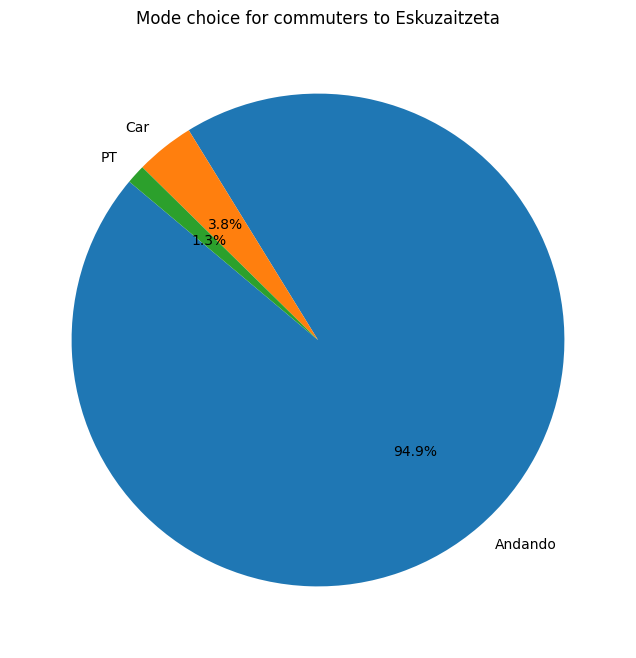

In [503]:
# Change BRT

trips_ez_1 = trips_ez.copy()
trips_ez_1['transit_tt_gm'] = trips_ez_1['transit_tt_gm'] * 0.4

x = np.array(trips_ez_1.drop(columns = ['Hora_Ini', 'Recur', 'Income', 'Income_Percentile', 'Mun_Des', 'Mun_Ori', 'O_long', 'O_lat', 'D_long', 'D_lat']))
y_pred = model.predict(x)
trips_ez_1['prediction'] = y_pred

unique_labels, counts = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Mode choice for commuters to Eskuzaitzeta')
plt.show()

In [504]:
trips_ez

,Hora_Ini,Hora_Ini_E,Recur,Per_hog,Turismos,Sexo,Edad,crnt_tur,Income,Income_Percentile,...,O_lat,D_long,D_lat,drive_tt,distance,walk_tt,transit_tt_gm,Tipo_familia,Mun_Ori,Mun_Des
0,18:00,217,22,2,2,2,5,1,21756.570,1,...,43.318235,-1.950277,43.316010,3.905783,2107.061,5.207483,3.877,4,69,67
1,13:30,163,23,1,1,1,5,2,23126.500,2,...,43.309720,-1.962965,43.312968,3.003950,1903.721,29.543150,15.007,1,69,67
2,16:00,193,22,2,2,2,5,2,22182.270,1,...,43.313659,-1.940400,43.317173,1.531650,707.630,9.030850,6.679,2,69,67
3,08:00,97,22,2,3,1,3,1,22642.935,2,...,43.319545,-1.958895,43.320405,0.000000,0.000,1.338533,1.341,2,69,67
4,19:00,229,22,1,2,2,5,1,24338.910,3,...,43.309174,-2.039706,43.308120,0.623400,249.375,5.286967,3.938,1,69,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,06:45,82,22,2,2,2,5,1,20843.250,1,...,43.181174,-2.313549,43.179317,0.877867,351.168,5.927917,4.418,4,17,69
2467,19:30,235,22,1,2,1,4,1,27790.760,4,...,43.103865,-2.291586,43.101620,16.021533,6495.834,8.292733,6.180,3,80,69
2468,19:30,235,22,1,2,1,4,1,27790.760,4,...,43.099684,-2.315477,43.096084,1.015717,455.270,7.600233,5.663,3,80,69
2469,19:30,235,22,1,2,1,4,1,27790.760,4,...,43.118066,-2.326982,43.119802,2.153850,861.560,14.359333,10.704,3,80,69


In [505]:
trips_ez_1.to_csv(f"results/dfs/{name}.csv")

## CREACIÓN DE ARCHIVOS HEXAGON Y ARCS

In [506]:
# Hexagon

trips_ez_1['COORDINATES'] = trips_ez_1.apply(lambda row: [row['O_long'], row['O_lat']], axis=1)

coordinates_list = trips_ez_1['COORDINATES'].apply(lambda x: {'COORDINATES': x}).tolist()

with open(name_hexagon, 'w') as f:
    json.dump(coordinates_list, f)

In [507]:
# Arcs

def determine_inbound(mode):
    if mode == "Car":
        return 1
    elif mode == "PT":
        return 2
    elif mode == "Andando":
        return 3
    else:
        return 0

json_list = [
    {
        "inbound": determine_inbound(row['prediction']),
        "from": {
            "coordinates": [row['O_long'], row['O_lat']]
        },
        "to": {
            "coordinates": [row['D_long'], row['D_lat']]
        }
    } for index, row in trips_ez_1.iterrows()
]

# Save the JSON structure to a file
with open(name_arc, 'w') as outfile:
    json.dump(json_list, outfile, indent=2)